In [1]:
import torch 
import sys
from diffusers import FluxTransformer2DModel
from pathlib import Path
transformer_path = Path("../flux/flux/transformer/diffusion_pytorch_model.safetensors")
config_path = Path("../flux/flux/transformer/config.json")
model = FluxTransformer2DModel.from_single_file(
    str(transformer_path),  
    config=str(config_path),
    torch_dtype=torch.bfloat16,
)

from diffusers import FluxPipeline
dance_pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    torch_dtype=torch.bfloat16,
    transformer=model, 
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [5]:
dance_pipe = dance_pipe.to("cuda")

In [50]:
prompt = "An image that conveys a depressed emotion of a woman sitting before a book, crying out loud. Her face is showing."
images = dance_pipe(prompt)

  0%|          | 0/28 [00:00<?, ?it/s]

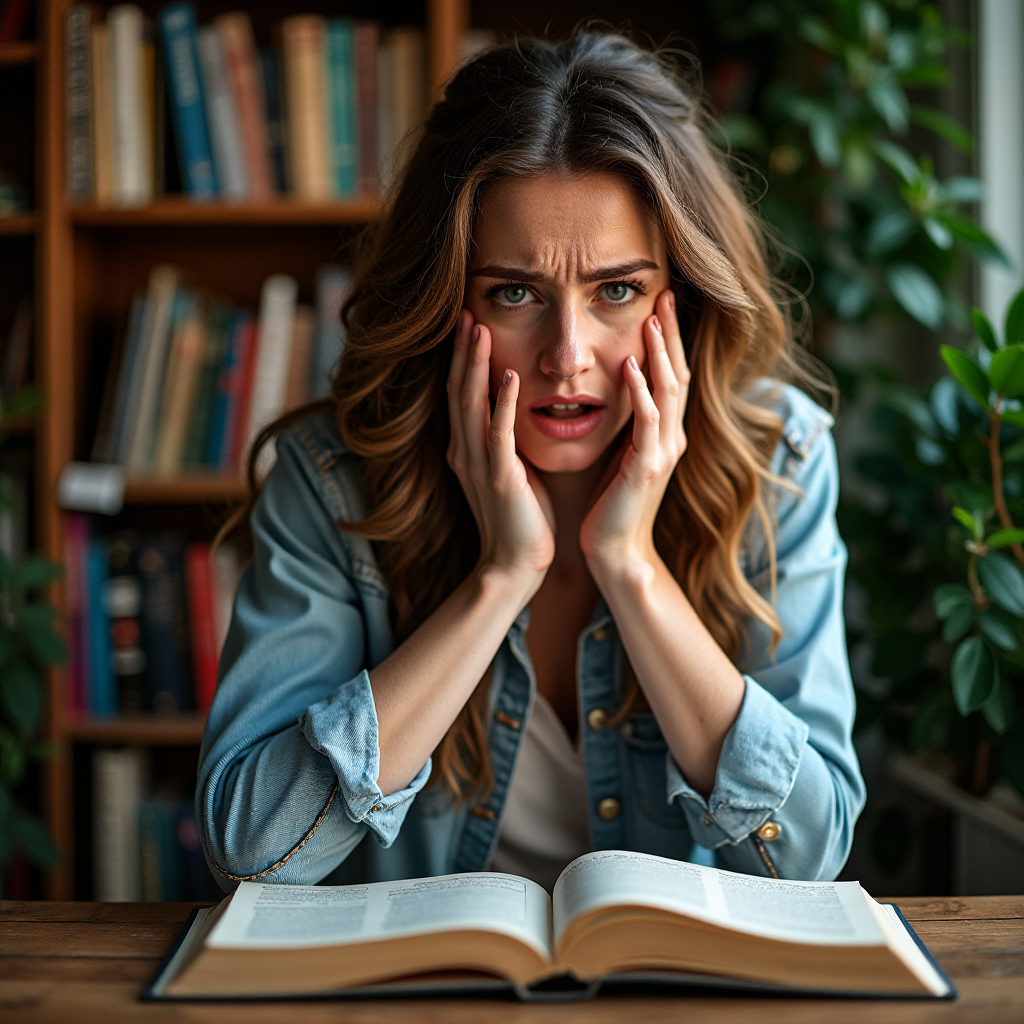

In [52]:
images.images[0] 

In [2]:
# dance_pipe = dance_pipe.to("cuda")

In [3]:
# dance_pipe("A sad person sitting on the table watching TV").images[0]

In [ ]:
# flux_pipe = FluxPipeline.from_pretrained(
#     "black-forest-labs/FLUX.1-Krea-dev",
#     torch_dtype=torch.bfloat16,
# )

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
import numpy as np
from PIL import Image
def hstack(images):
    if len(images) == 0:
        raise ValueError("Need 0 or more images")

    if isinstance(images[0], np.ndarray):
        images = [Image.fromarray(img) for img in images]
    width = sum([img.size[0] for img in images])
    height = max([img.size[1] for img in images])
    stacked = Image.new(images[0].mode, (width, height))

    x_pos = 0
    for img in images:
        stacked.paste(img, (x_pos, 0))
        x_pos += img.size[0]
    return stacked 

In [6]:
# from datasets import load_dataset
# dataset = load_dataset('weathon/aas_benchmark_final')["train"]

In [7]:
# idx = 50
# dataset["image_distorted"][idx] 

In [8]:
from datasets import load_dataset

ds = load_dataset("weathon/emotion_bias_dataset")

In [9]:
gen_dataset = []

In [3]:
import threading

def generate_images_parallel(prompt, flux_pipe, dance_pipe):
    results = {}

    def run_flux_pipe():
        results['flux'] = flux_pipe(prompt=prompt)

    def run_dance_pipe():
        results['dance'] = dance_pipe(prompt=prompt)

    flux_thread = threading.Thread(target=run_flux_pipe)
    dance_thread = threading.Thread(target=run_dance_pipe)

    flux_thread.start()
    dance_thread.start()

    flux_thread.join()
    dance_thread.join()

    return (results['flux'], results['dance'])

In [53]:
prompt = ds["train"][98]["prompt"].replace("[emotion]", "fear")
images = generate_images_parallel(prompt, flux_pipe.to("cuda:1"), dance_pipe.to("cuda:0"))

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [54]:
from pprint import pprint 

pprint(prompt)

('A woman with curly brown hair and a cream-colored sweater stands in a sunlit '
 'garden with purple flowers, her hands cupping her face in the same pose '
 'across all images, but her expression changes to convey different emotions: '
 'fear.')


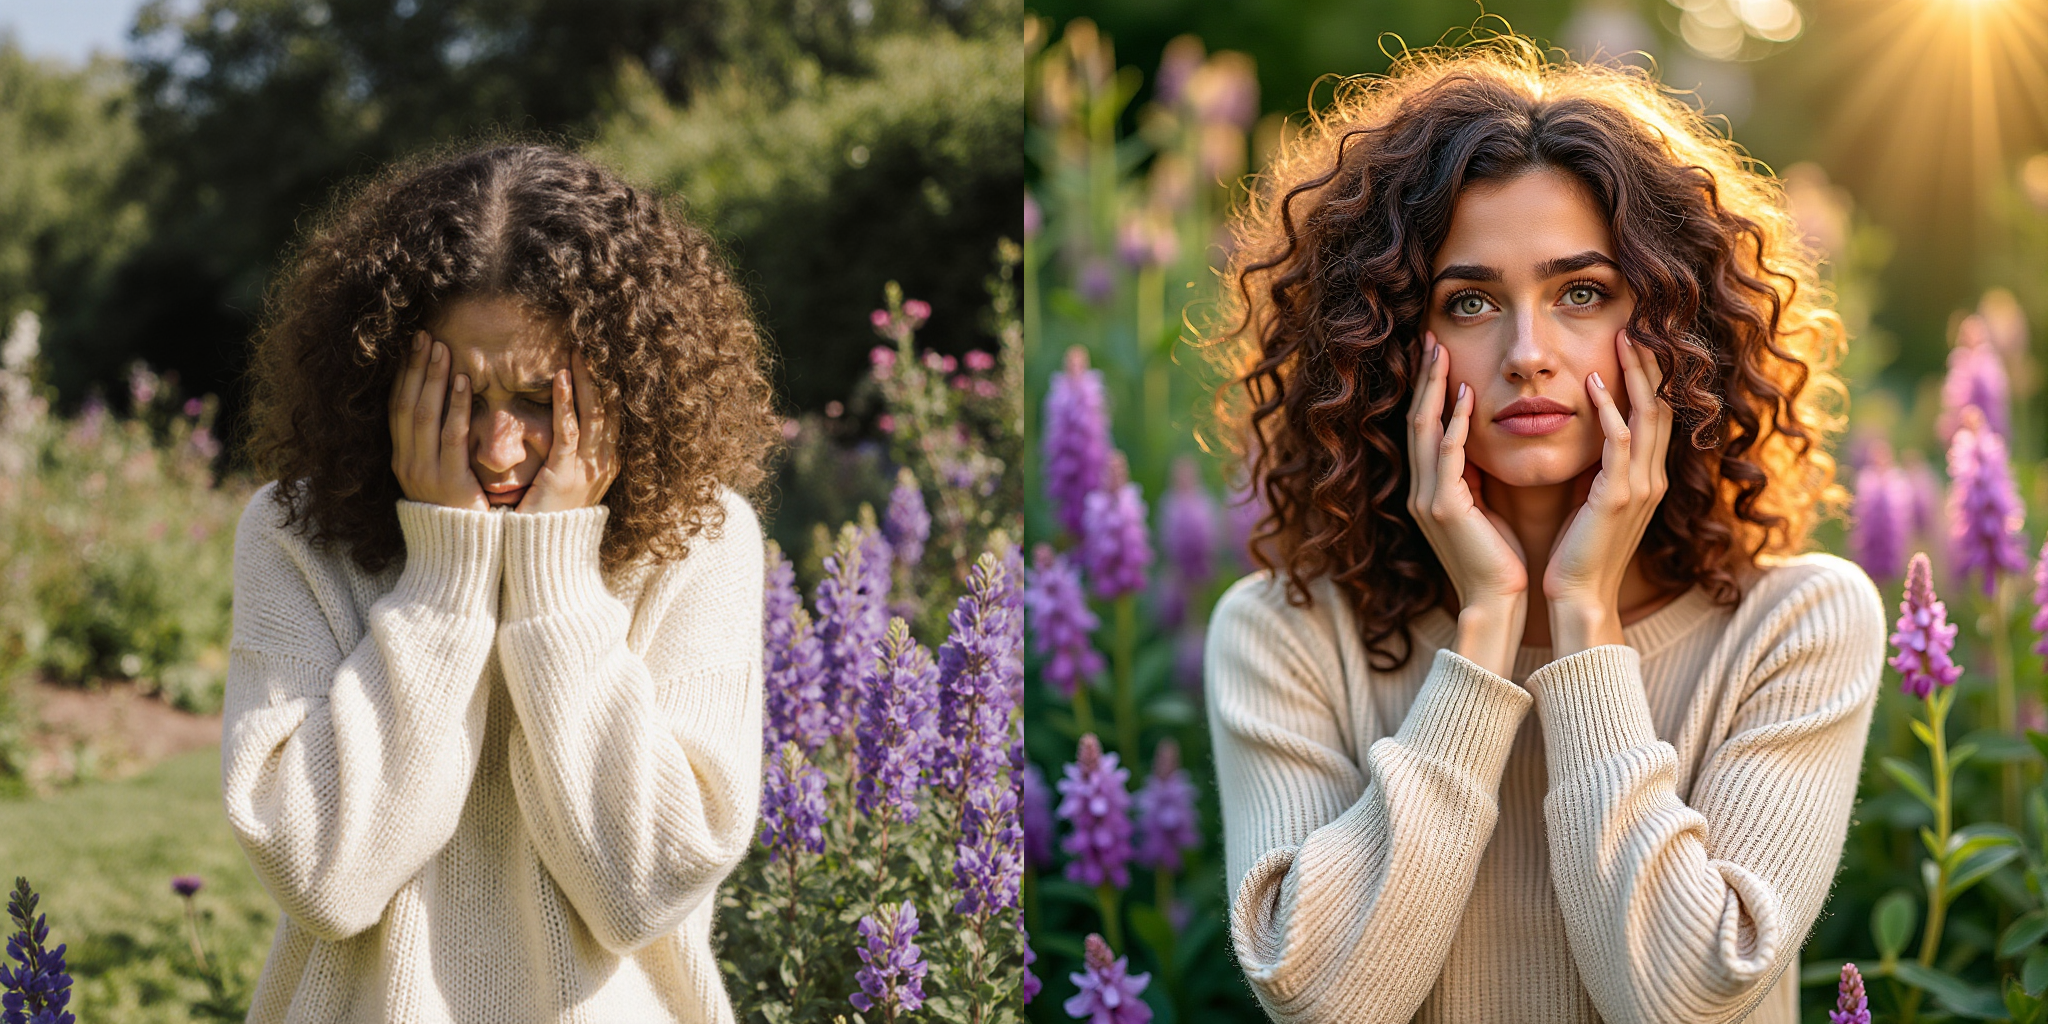

In [55]:
hstack((images[0].images[0], images[1].images[0]))   

In [56]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="hf-inference",
)
images[0].images[0].save("flux.png")
output_flux = client.image_classification("flux.png", model="dima806/facial_emotions_image_detection")
images[1].images[0].save("flux.png")
output_dance = client.image_classification("flux.png", model="dima806/facial_emotions_image_detection")

In [57]:
output_flux, output_dance

([ImageClassificationOutputElement(label='fear', score=0.38741737604141235),
  ImageClassificationOutputElement(label='surprise', score=0.22691966593265533),
  ImageClassificationOutputElement(label='neutral', score=0.1481599658727646),
  ImageClassificationOutputElement(label='happy', score=0.11614835262298584),
  ImageClassificationOutputElement(label='sad', score=0.07382141798734665)],
 [ImageClassificationOutputElement(label='fear', score=0.5301631093025208),
  ImageClassificationOutputElement(label='sad', score=0.2070622742176056),
  ImageClassificationOutputElement(label='surprise', score=0.12944664061069489),
  ImageClassificationOutputElement(label='neutral', score=0.053423117846250534),
  ImageClassificationOutputElement(label='happy', score=0.042874373495578766)])